In [1]:
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
from fasta_iterator_class import FASTAReader

dna_align_file = '/Users/cmdb/qbb2020-answers/week4-hw/aligned.fa'

aligned_seqs = FASTAReader(open(dna_align_file))
align_seq_list = []; seq_id_list = []; seq_dict = {}

codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

tM = 0; dS = 0; dN = 0;
mut_dict ={}
for seq_id, aligned_seq in aligned_seqs:
    align_seq = aligned_seq.replace('-','')
    
    if seq_id == 'query':
        query = align_seq
        continue  
    if len(query) < len(align_seq): length = len(query)
    else: length = len(align_seq)
    for nuc in range(0, length - 2, 3): 
        codon_query = query[nuc: nuc+3]
        codon_align = align_seq[nuc: nuc+3]
        codon_position = nuc/3
        seq_dict.setdefault(codon_position, [dS,dN])
        unknown_nuc = ['Y', 'R', 'W', 'S', 'M', 'N', 'K']
        if any(nuc in unknown_nuc for nuc in codon_align):
            continue
        aa_query = codontable[codon_query]
        aa_align = codontable[codon_align]
        
        if aa_align == aa_query and codon_query != codon_align: 
            seq_dict[codon_position][0] +=1
        elif aa_align != aa_query and codon_query != codon_align: 
            seq_dict[codon_position][1] +=1
header = ['dS', 'dN']
seq_df = pd.DataFrame.from_dict(seq_dict, orient = 'index', columns = header)

In [2]:
seq_df['log2(dN/dS)'] = np.log2(seq_df['dN']/seq_df['dS'])
seq_df = seq_df.reset_index()
seq_df.columns.values[0] = "codon_position"

In [20]:
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as stests
z = stats.zscore(seq_df['dN'] - seq_df['dS'])
seq_df['p'] = stats.norm.sf(abs(z))*2
seq_df_no_zeros = seq_df[(seq_df['dS'] != 0) & (seq_df['dN'] != 0)]
seq_df_no_zeros

,codon_position,dS,dN,log2(dN/dS),p
1,1.0,361,557,0.625678,0.000044
2,2.0,15,900,5.906891,0.982576
3,3.0,2,911,8.831307,0.869008
4,4.0,10,906,6.501439,0.930340
5,5.0,10,902,6.495056,0.949312
...,...,...,...,...,...
3425,3425.0,286,593,1.052017,0.000617
3426,3426.0,1,886,9.791163,0.982576
3427,3427.0,6,881,7.198036,0.969865
3428,3428.0,37,850,4.521866,0.683714


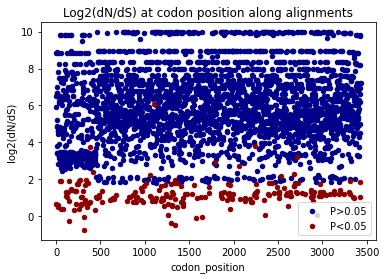

In [21]:
import matplotlib.pyplot as plt

#not significant
seq_df_ns = seq_df_no_zeros[seq_df_no_zeros['p'] > 0.05]
#significant 
seq_df_s = seq_df_no_zeros[seq_df_no_zeros['p'] < 0.05]
ax1 = seq_df_ns.plot.scatter(x='codon_position',y='log2(dN/dS)',c='DarkBlue')
ax1 = seq_df_s.plot.scatter(x='codon_position',y='log2(dN/dS)',c='DarkRed', ax = ax1)
plt.title('Log2(dN/dS) at codon position along alignments')
plt.legend(['P>0.05', 'P<0.05'])